# Gaussian Mixture Model(Application)

在写代码之前我们需要注意一下几个点:

- [多元正态分布](https://zh.wikipedia.org/wiki/%E5%A4%9A%E5%85%83%E6%AD%A3%E6%80%81%E5%88%86%E5%B8%83)

- 在理论上多元正态分布的参数$\Sigma$是需要半正定和非奇异的,但是由于EM是迭代算法,所以在迭代的过程中可能会产生一些奇异的矩阵,所以我们在使用[multivariate_normal](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.multivariate_normal.html)计算多元正态分布的时候我们需要调节参数
    - allow_singular=True
- 参数$\Sigma$必须要是半正定的.

### 1 Import package

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import  train_test_split
import matplotlib.pyplot as plt
from sklearn import mixture
from scipy.stats import multivariate_normal

### 2 Load Data

这里的数据集使用的是来自于sklearn的鸢尾花数据集数据集的futures我们选择：
- sepal length,sepal width

另外由于GMM是非监督学习,在训练过程中我们不需要使用label,但是我们依然要拿出label以方便于后面正确率的比较

In [2]:
# data
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
    data = np.array(df.iloc[:100, [0, 1, -1]])
    return data[:,:2], data[:,-1]

In [3]:
X, y = create_data()

绘制源数据样本

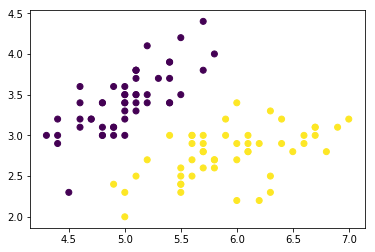

In [4]:
plt.scatter(X[:,0],X[:,1],c=y)

可以看出鸢尾花数据集有两类,一类是上方的紫色,一类是下方的黄色,所以我们如果要对此数据集进行GMM训练,那么C是2.

其中C代表高斯模型的数量

### 2 各个参数的维度


如果存在C个高斯的混合模型,且源数据X的形状是(m,d):
- m: Number of sample,d:Dimension or fetures.


$\alpha_l$: 每一个高斯模型都含有一个权重$\alpha$,所以$\alpha$的形状是(C,),初始值我们一般都选择$\frac{1}{C}$是比较合理的.

$\mu_l$: 每一个高斯模型都含有一个$\mu$,且在多元正态分布中单个样本的各个特征都有一个对应的$\mu_i$,所以$\mu$的形状是(C,d)

$\Sigma_l$: 每一个高斯模型都含有一个协方差矩阵$\Sigma$,且每一个协方差矩阵中的形状是(d,d),所以$\Sigma$的形状是(C,d,d)

$p(Z|X,\theta) = \gamma$:每一个高斯模型都能够给予一个样本点在自身高斯模型下的概率,所以$\gamma$的形状应该是(m,C)

d:查看特征数量

In [5]:
d = X.shape[1]

定义初始化的$\alpha$:

$\alpha=\frac{1}{C}$

In [6]:
C = 2
alpha = np.ones(C,dtype=np.float32) * (1.0 / C)
alpha

array([0.5, 0.5], dtype=float32)

初始化的$\mu$:

shape of mu = (C,d)

这里初始化的值最好选用服从standard normal的数值

In [7]:
mu = np.random.randn(C,d)
mu

array([[-1.17486181, -0.06712657],
       [-1.03529541, -0.64314317]])

初始化$\Sigma$:

在初始化协方差$\Sigma$的时候我们需要先建立三维数组(C,d,d)以方便后面代码中的循环,保证每次循环出来的是满足非正定的方正(对称矩阵)

![](picture/47.png)



In [8]:
Sigma_ = np.random.randn(C,d,d)
Sigma_

array([[[-2.28610277, -0.91489788],
        [ 0.42983595, -1.28783044]],

       [[ 0.4160969 , -1.15355051],
        [ 1.71037245, -2.58518104]]])

In [9]:
Sigma = np.array([np.dot(A,A.T) for A in Sigma_])
Sigma

array([[[6.06330399, 0.19558418],
        [0.19558418, 1.84326618]],

       [[1.50381541, 3.69381757],
        [3.69381757, 9.60853489]]])

### 3 Model

#### 3.1 建立初始化函数,里面包括了$\alpha,\mu,\Sigma$的初始化方式

In [10]:
def initial_parameters(C,d):
    """
    initialization parameters.
    
    Parameters:
    ----------
        C: Number of Gaussian model.
        d:dimension
        
    Returns:
    -------
        parameter of Gaussian model.
        alpha: shape = (C,)
        mu:shape=(C,d)
        Sigma:(C,d,d)
    """
    
    np.random.seed(1)
    alpha = np.ones(C,dtype=np.float32) * (1.0 / C)
    mu = np.random.randn(C,d)
    Sigma_ = np.random.randn(C,d,d)
    Sigma = np.array([np.dot(A,A.T) for A in Sigma_])
    
    return alpha,mu,Sigma

In [11]:
d = X.shape[1]
C = 2
alpha,mu,Sigma = initial_parameters(C=C,d = d)
print('alpha:{}\nmu:{},\nSigma:{}'.format(alpha,mu,Sigma))

alpha:[0.5 0.5]
mu:[[ 1.62434536 -0.61175641]
 [-0.52817175 -1.07296862]],
Sigma:[[[6.04601074 3.26192055]
  [3.26192055 3.62380404]]

 [[0.16397153 0.98020766]
  [0.98020766 6.38193936]]]


#### 3.2 Start E-step

E-step:
- 我们需要直接从后验概率$P(z|x,\theta)$计算

$P(z_{ik}|x_i,\theta_k)=\frac{\alpha_k N(x_i|\theta_k)}{\sum_{k}^{K}\alpha_k N(x_i|\theta_k)}$

**Ps:**
- 使用multivariate_normal.pdf来计算多元正态的值
- allow_singular=True:允许奇异矩阵
- gamma:响应度,也就是说它能给出某一个样本点属于某一个高斯模型的概率

In [12]:
def E_step(X,alpha,mu,Sigma):
    """
    Implementation E step.
    The gamma equal posterior probability.
    
    Parameters:
    ----------
        X: input data, training set.
        parameters of Gaussian model:
            1.alpha
            2.mu
            3.Sigma
    Return:
    ------
        gamma:response probability.
    """
    m,d = X.shape
    C = alpha.shape[0]
    gamma = np.zeros(shape=(m,C))
    
    for i in range(C):
        gamma[:,i] = multivariate_normal.pdf(X,mean=mu[i],cov=Sigma[i],allow_singular=True)
        
    gamma *= alpha[i]
    gamma = gamma / np.sum(gamma,axis=1,keepdims= True)
    
    return gamma
    
    
    

In [13]:
gamma = E_step(X,alpha,mu,Sigma)
print('gamma:{}'.format(gamma[:10]))

gamma:[[1.00000000e+000 0.00000000e+000]
 [1.00000000e+000 0.00000000e+000]
 [1.00000000e+000 0.00000000e+000]
 [1.00000000e+000 0.00000000e+000]
 [1.00000000e+000 0.00000000e+000]
 [1.00000000e+000 0.00000000e+000]
 [1.00000000e+000 1.71708069e-318]
 [1.00000000e+000 0.00000000e+000]
 [1.00000000e+000 3.94586944e-301]
 [1.00000000e+000 0.00000000e+000]]


可以看出在测试迭代中,gamma的第一行代表第一个样本属于两个高斯的概率:

可以看出第一个样本属于第一个高斯的概率为1,这不一定是正确的,因为只是初次迭代.

#### 3.3 M-step:

M-step负责更新参数,需要注意的是:

在更新$\Sigma$的时候需要使用外积[np.outer](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.outer.html)计算,这样的出来的结果才是半正定的,另外不能保证$\Sigma$非奇异,原因开始的时候已经说明.

在取出gamma中的值计算的时候,由于Numpy的影响,我们需要增加一个维度np.newaxis来使得两个向量可以计算.

$\alpha=\frac{\sum_{i=1}^{N}P(z_{ik}|x_i,\theta_k)}{N}$

$\mu=\frac{\sum_{i=1}^{N}P(z_{ik}|x_i,\theta_k)x_i}{\sum_{i=1}^{N}P(z_{ik}|x_i,\theta_k)}$

$\Sigma=\frac{\sum_{i=1}^{N}[x_i-\mu_k][x_i-\mu_k]^T P(z_{ik}|x_i,\theta_k)}{\sum_{i=1}^{N}P(z_{ik}|x_i,\theta_k)}$

In [14]:
def M_step(X,gamma):
    """
    Update parameters.
    
    Parameters:
    ---------
        X: training set.
        gamma: response probability.
    Return:
    ------
        parameters of Gaussian mixture model.
        1.alpha
        2.mu
        3.Sigma
    """
    
    m,d = X.shape
    C = gamma.shape[1]
    alpha = np.zeros(C)
    mu = np.zeros((C,d))
    Sigma = np.zeros((C,d,d))
    
    for c in range(C):
        # gamma[:,c][:,np.newaxis]: add axis in gamma[:,c]'s column
        alpha[c] = np.sum(gamma[:,c]) / m
        mu[c,:]= np.sum(gamma[:,c][:,np.newaxis] * X,axis=0) / np.sum(gamma[:,c])
        # Sigma:singular matrix maybe.
        Sigma[c,:] = np.sum([gamma[i,c] * np.outer(X[i] - mu[c], X[i] - mu[c]) for i in range(m)], axis=0) / np.sum(gamma[:,c])
        
    return alpha,mu,Sigma

In [15]:
alpha,mu,Sigma = M_step(X,gamma)
print('alpha:{}\nmu:{},\nSigma:{}'.format(alpha,mu,Sigma))

alpha:[1.00000000e+000 3.37351249e-287]
mu:[[5.471 3.099]
 [4.3   3.   ]],
Sigma:[[[ 4.07659000e-01 -6.26290000e-02]
  [-6.26290000e-02  2.26899000e-01]]

 [[ 3.46134332e-12  6.92234261e-12]
  [ 6.92234261e-12  1.38446887e-11]]]


#### 3.4 Build GMM

现在可以开始建立模型GMM

这里我们会设置一个threshold,来使得在迭代过程中如果满足threshold,则退出迭代.因为在threshold内如果保证了gamma的收敛,我们就没有必要继续迭代了.

In [16]:
def GMM(X,C,iter_,threshold):
    """
    Build Gaussian Mixture Model.
    
    Parameters:
    ----------
        X: training data (m,d)
        iter_: number of iteration.
        threshold: threshold value,stop condition.
    Return:
    ------
        The best parameters:
            1.alpha
            2.mu
            3.Sigma
    """
    d = X.shape[1]
    alpha,mu,Sigma = initial_parameters(C=C,d = d)

    for Iter in range(iter_):
        
        Sigma_prev = Sigma
        gamma = E_step(X,alpha,mu,Sigma)
        alpha,mu,Sigma = M_step(X,gamma)
        if (Sigma - Sigma_prev).all() <= threshold:  # stop condition.
            break
    return alpha,mu,Sigma

In [17]:
best_alpha,best_mu,best_Sigma = GMM(X,2,100,1e-3)
print(best_alpha)
print(best_mu)
print(best_Sigma)

[0.51200563 0.48799437]
[[5.90469714 2.76321348]
 [5.01596323 3.45130855]]
[[[0.29682856 0.09213082]
  [0.09213082 0.09904272]]

 [[0.11953613 0.08810494]
  [0.08810494 0.11862454]]]


现在,已经得到了当前最优的参数模型,那么我们将其带入E-step中求出后验概率,并且后验概率中每一组预测值中最大的索引作为分类标签.

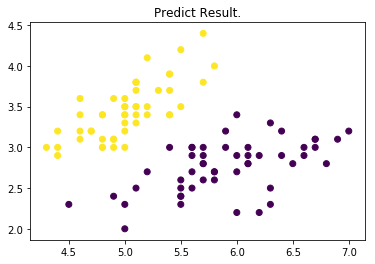

In [18]:
gamma = E_step(X,alpha=best_alpha,mu = best_mu,Sigma=best_Sigma)
labels = gamma.argmax(axis=1) # axis=1,按照列之间来比较,取出概率最大的一个应对于某一个样本点属于某一个高斯.
plt.scatter(X[:,0],X[:,1],c=labels)
plt.title('Predict Result.')
plt.show()

可以看出预测的结果是可以的,只有貌似左下角的点分类错误

对于这种简单的样本GMM模型是可以的,由于是非监督算法,那么正确率是肯定会低于监督算法的.

### 4. plot Gaussian Mixture Model

下面我们来动态的看看整个训练过程中GMM的变化.

在Jupyter中,我们可以使用:
- %matplotlib inline
- from IPython import display

来绘制动态过程.

在绘制过程中,我们需要使用[clabel](https://matplotlib.org/gallery/images_contours_and_fields/contour_demo.html#sphx-glr-gallery-images-contours-and-fields-contour-demo-py)来绘制等高线.

In [19]:
def plotGaussian(X,mu,Sigma):
    %matplotlib inline
    from IPython import display
    
    # meshgraid
    x = np.linspace(0., 8.,num=100)
    y = np.linspace(0., 5.,num=100)
    xx, yy = np.meshgrid(x, y)
    meshgrid_X = np.array([xx.ravel(), yy.ravel()]).T 
    fig, ax = plt.subplots()
    
    C = X.shape[1]
    # plot two Gaussian model.
    for c in range(C):
        Z = multivariate_normal.pdf(meshgrid_X,mean=mu[c],cov=Sigma[c],allow_singular=True)
        Z = Z.reshape(xx.shape)
        CS = ax.contour(xx, yy, Z)
        ax.clabel(CS, inline=False, fontsize=False)
    
    ax.scatter(X[:,0],X[:,1],c=labels)
    plt.xlim(X[:,0].min(),X[:,0].max())
    plt.ylim(X[:,1].min(),X[:,1].max())
    plt.xticks(()) # hide x,y ticks
    plt.yticks(())
    plt.title('Gaussian Mixture Model')
    plt.pause(0.1)
    plt.show()
    display.clear_output(wait=True)

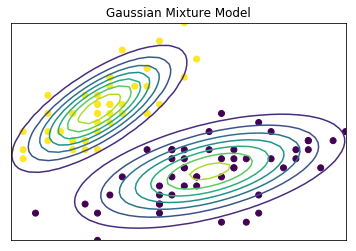

In [20]:
plotGaussian(X,best_mu,best_Sigma)

#### 4.1 Gaussian fitting animation

In [21]:
def Gaussian_Fitting_Animation(X,C,iter_,threshold):
    
    d = X.shape[1]
    
    alpha,mu,Sigma = initial_parameters(C=C,d = d)

    for Iter in range(iter_):
        
        Sigma_prev = Sigma
        gamma = E_step(X,alpha,mu,Sigma)
        alpha,mu,Sigma = M_step(X,gamma)
        plotGaussian(X,mu=mu,Sigma=Sigma)
        if (Sigma - Sigma_prev).all() <= threshold:  # 迭代停止条件
            break

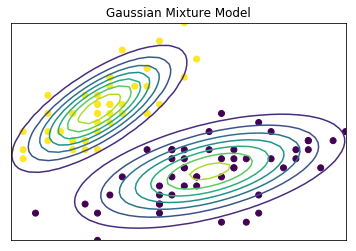

In [22]:
Gaussian_Fitting_Animation(X=X,C=2,iter_=100,threshold=1e-3)

### 5 Scikit-learn

我们也可以使用scikit-learn来快速实现GMM

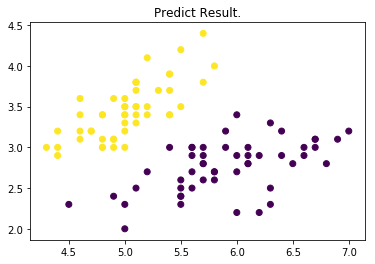

In [23]:
from sklearn import mixture

gmm = mixture.GaussianMixture(n_components=2,covariance_type='full')
gmm.fit(X)
labels = gmm.predict(X)
plt.scatter(X[:,0],X[:,1],c=labels)
plt.title('Predict Result.')
plt.show()

可以看出结果与我们自身编写的GMM是类似的.

### 6. Summary

- 在编写GMM的过程中,很显然理论上的方法和代码中可能不一样,典型的就是$\Sigma$参数.
- 这里没有定义损失函数.损失函数有很多有[常见的分类和回归的损失函数](https://www.cnblogs.com/massquantity/p/8964029.html)你也可以自己选择正确的使用,当然你也可以定义之前我们的损失函数KL.


### Homework:

将data_set文件中的GMM_data数据集使用GMM模型进行拟合.

Good Luck~~